# Lab 02: Seq2Seq Model


Build a **Date Format Converter** that translates dates from various formats to a standard format:

- Input: "25th of December 2023", "Dec 25, 2023", "25-12-2023"

- Output: "2023-12-25"

In [1]:
# Install required packages
!pip install torch matplotlib tqdm -q

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from datetime import datetime, timedelta

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Data

In [3]:
import pandas as pd
df = pd.read_csv('date_pairs_sample.csv')
inputs = df['Input'].tolist()
targets = df['Output'].tolist()
data_pairs = list(zip(inputs, targets))

## 2. Vocabulary Building

In [4]:
class Vocabulary:
    def __init__(self):
        self.char2idx = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.idx2char = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.n_chars = 4
    
    def build_vocabulary(self, texts):
        chars = set()
        for text in texts:
            chars.update(list(text))
        
        for char in sorted(chars):
            if char not in self.char2idx:
                self.char2idx[char] = self.n_chars
                self.idx2char[self.n_chars] = char
                self.n_chars += 1
        
        print(f"Vocabulary size: {self.n_chars}")
        print(f"Characters: {sorted([c for c in self.char2idx.keys() if c not in ['<PAD>', '<SOS>', '<EOS>', '<UNK>']])}")
    
    def encode(self, text, add_sos=False, add_eos=False):
        indices = []
        if add_sos:
            indices.append(self.char2idx["<SOS>"])
        indices.extend([self.char2idx.get(c, self.char2idx["<UNK>"]) for c in text])
        if add_eos:
            indices.append(self.char2idx["<EOS>"])
        return indices
    
    def decode(self, indices):
        chars = []
        for idx in indices:
            if idx in [self.char2idx["<PAD>"], self.char2idx["<SOS>"], self.char2idx["<EOS>"]]:
                continue
            chars.append(self.idx2char.get(idx, "<UNK>"))
        return ''.join(chars)

# Build vocabularies
src_vocab = Vocabulary()
tgt_vocab = Vocabulary()

all_sources = [src for src, _ in data_pairs]
all_targets = [tgt for _, tgt in data_pairs]

src_vocab.build_vocabulary(all_sources)
tgt_vocab.build_vocabulary(all_targets)

Vocabulary size: 21
Characters: [' ', '-', '/', '0', '1', '2', '3', '6', '7', '8', '9', 'a', 'j', 'n', 'p', 'r', 'u']
Vocabulary size: 14
Characters: ['-', '0', '1', '2', '3', '4', '6', '7', '8', '9']


## 3. Dataset Class

In [5]:
class DateDataset(Dataset):
    def __init__(self, pairs, src_vocab, tgt_vocab):
        self.pairs = pairs
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        
        src_indices = self.src_vocab.encode(src)
        tgt_indices = self.tgt_vocab.encode(tgt, add_sos=True, add_eos=True)
        
        return (
            torch.tensor(src_indices, dtype=torch.long),
            torch.tensor(tgt_indices, dtype=torch.long)
        )

def collate_fn(batch):
    """Custom collate function to pad sequences"""
    src_batch, tgt_batch = zip(*batch)
    
    # Get lengths
    src_lengths = torch.tensor([len(s) for s in src_batch], dtype=torch.long)
    
    # Pad sequences
    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=0)
    tgt_padded = pad_sequence(tgt_batch, batch_first=True, padding_value=0)
    
    return src_padded, tgt_padded, src_lengths

# Split data
train_size = int(0.8 * len(data_pairs))
train_pairs = data_pairs[:train_size]
val_pairs = data_pairs[train_size:]

train_dataset = DateDataset(train_pairs, src_vocab, tgt_vocab)
val_dataset = DateDataset(val_pairs, src_vocab, tgt_vocab)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, collate_fn=collate_fn)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Train samples: 4
Validation samples: 1


## 4. Encoder Architecture

In [6]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers=1, dropout=0.3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(
            embed_dim, 
            hidden_dim, 
            n_layers, 
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src, src_lengths):
        """
        Args:
            src: [batch_size, src_len]
            src_lengths: [batch_size]
        Returns:
            hidden: [n_layers, batch_size, hidden_dim]
        """
        # Embed
        embedded = self.dropout(self.embedding(src))  # [batch, src_len, embed_dim]
        
        # Pack padded sequence
        packed = pack_padded_sequence(
            embedded, src_lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        # GRU forward
        outputs, hidden = self.gru(packed)
        
        # hidden: [n_layers, batch, hidden_dim]
        return hidden

# Test encoder
encoder = Encoder(
    vocab_size=src_vocab.n_chars,
    embed_dim=128,
    hidden_dim=256,
    n_layers=2
).to(device)

print(encoder)
print(f"\nEncoder parameters: {sum(p.numel() for p in encoder.parameters()):,}")

Encoder(
  (embedding): Embedding(21, 128, padding_idx=0)
  (gru): GRU(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
)

Encoder parameters: 693,888


## 5. Decoder Architecture

In [7]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers=1, dropout=0.3):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(
            embed_dim,
            hidden_dim,
            n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input_token, hidden):
        """
        Args:
            input_token: [batch_size, 1]
            hidden: [n_layers, batch_size, hidden_dim]
        Returns:
            prediction: [batch_size, vocab_size]
            hidden: [n_layers, batch_size, hidden_dim]
        """
        # Embed
        embedded = self.dropout(self.embedding(input_token))  # [batch, 1, embed_dim]
        
        # GRU step
        output, hidden = self.gru(embedded, hidden)
        # output: [batch, 1, hidden_dim]
        
        # Predict next token
        prediction = self.fc_out(output.squeeze(1))  # [batch, vocab_size]
        
        return prediction, hidden

# Test decoder
decoder = Decoder(
    vocab_size=tgt_vocab.n_chars,
    embed_dim=128,
    hidden_dim=256,
    n_layers=2
).to(device)

print(decoder)
print(f"\nDecoder parameters: {sum(p.numel() for p in decoder.parameters()):,}")

Decoder(
  (embedding): Embedding(14, 128, padding_idx=0)
  (gru): GRU(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (fc_out): Linear(in_features=256, out_features=14, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Decoder parameters: 696,590


## 6. Seq2Seq Model

In [8]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    
    def forward(self, src, src_lengths, tgt, teacher_forcing_ratio=0.5):
        """
        Args:
            src: [batch_size, src_len]
            src_lengths: [batch_size]
            tgt: [batch_size, tgt_len]
            teacher_forcing_ratio: probability of using teacher forcing
        Returns:
            outputs: [batch_size, tgt_len, vocab_size]
        """
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.vocab_size
        
        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)
        
        # Encode
        hidden = self.encoder(src, src_lengths)
        
        # First decoder input is <SOS> token
        decoder_input = tgt[:, 0:1]  # [batch, 1]
        
        for t in range(1, tgt_len):
            # Decode one step
            output, hidden = self.decoder(decoder_input, hidden)
            
            # Store output
            outputs[:, t, :] = output
            
            # Teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            
            # Get predicted token
            top1 = output.argmax(1).unsqueeze(1)  # [batch, 1]
            
            # Next input: teacher forcing or predicted
            decoder_input = tgt[:, t:t+1] if teacher_force else top1
        
        return outputs
    
    def translate(self, src, src_lengths, max_len=15, sos_idx=1, eos_idx=2):
        """Greedy decoding for inference"""
        self.eval()
        batch_size = src.shape[0]
        
        with torch.no_grad():
            # Encode
            hidden = self.encoder(src, src_lengths)
            
            # Start with <SOS>
            decoder_input = torch.full((batch_size, 1), sos_idx, dtype=torch.long).to(self.device)
            
            translations = []
            
            for _ in range(max_len):
                output, hidden = self.decoder(decoder_input, hidden)
                top1 = output.argmax(1).unsqueeze(1)
                translations.append(top1)
                decoder_input = top1
                
                # Stop if all sequences have <EOS>
                if (top1 == eos_idx).all():
                    break
            
            translations = torch.cat(translations, dim=1)  # [batch, length]
        
        return translations

# Create model
model = Seq2Seq(encoder, decoder, device).to(device)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")


Total parameters: 1,390,478


## 7. Training

In [9]:
def train_epoch(model, dataloader, optimizer, criterion, clip, teacher_forcing_ratio):
    model.train()
    epoch_loss = 0
    
    for src, tgt, src_lengths in tqdm(dataloader, desc="Training"):
        src, tgt = src.to(device), tgt.to(device)
        src_lengths = src_lengths.to(device)
        
        optimizer.zero_grad()
        
        # Forward
        output = model(src, src_lengths, tgt, teacher_forcing_ratio)
        
        # Calculate loss (ignore <SOS> token)
        output_dim = output.shape[-1]
        output = output[:, 1:].contiguous().view(-1, output_dim)
        tgt = tgt[:, 1:].contiguous().view(-1)
        
        loss = criterion(output, tgt)
        
        # Backward
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        epoch_loss += loss.item()
    
    return epoch_loss / len(dataloader)


def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for src, tgt, src_lengths in tqdm(dataloader, desc="Evaluating"):
            src, tgt = src.to(device), tgt.to(device)
            src_lengths = src_lengths.to(device)
            
            # Forward (no teacher forcing)
            output = model(src, src_lengths, tgt, teacher_forcing_ratio=0)
            
            # Calculate loss
            output_dim = output.shape[-1]
            output = output[:, 1:].contiguous().view(-1, output_dim)
            tgt = tgt[:, 1:].contiguous().view(-1)
            
            loss = criterion(output, tgt)
            epoch_loss += loss.item()
    
    return epoch_loss / len(dataloader)

In [10]:
# Training setup
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore <PAD>
CLIP = 1.0
NUM_EPOCHS = 15

train_losses = []
val_losses = []

best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    # Decrease teacher forcing ratio over time
    teacher_forcing_ratio = 1.0 - (epoch / NUM_EPOCHS) * 0.5
    
    train_loss = train_epoch(model, train_loader, optimizer, criterion, CLIP, teacher_forcing_ratio)
    val_loss = evaluate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Teacher Forcing Ratio: {teacher_forcing_ratio:.2f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'seq2seq_basic_best.pt')
        print("  ✓ Saved best model!")

Evaluating: 100%|██████████| 1/1 [00:00<00:00, 350.11it/s]



Epoch 1/15
  Train Loss: 2.6388
  Val Loss: 2.4804
  Teacher Forcing Ratio: 1.00
  ✓ Saved best model!


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 400.76it/s]



Epoch 2/15
  Train Loss: 2.4514
  Val Loss: 2.3178
  Teacher Forcing Ratio: 0.97
  ✓ Saved best model!


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 332.46it/s]



Epoch 3/15
  Train Loss: 2.2566
  Val Loss: 2.1388
  Teacher Forcing Ratio: 0.93
  ✓ Saved best model!


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 280.99it/s]



Epoch 4/15
  Train Loss: 2.0992
  Val Loss: 2.0122
  Teacher Forcing Ratio: 0.90
  ✓ Saved best model!


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 387.57it/s]



Epoch 5/15
  Train Loss: 1.8823
  Val Loss: 1.8481
  Teacher Forcing Ratio: 0.87
  ✓ Saved best model!


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 275.40it/s]



Epoch 6/15
  Train Loss: 1.7922
  Val Loss: 1.9455
  Teacher Forcing Ratio: 0.83


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 293.08it/s]



Epoch 7/15
  Train Loss: 1.7232
  Val Loss: 1.9241
  Teacher Forcing Ratio: 0.80


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 340.83it/s]



Epoch 8/15
  Train Loss: 1.6357
  Val Loss: 1.9014
  Teacher Forcing Ratio: 0.77


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 353.47it/s]



Epoch 9/15
  Train Loss: 1.6423
  Val Loss: 1.8712
  Teacher Forcing Ratio: 0.73


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 385.65it/s]



Epoch 10/15
  Train Loss: 1.5883
  Val Loss: 1.8769
  Teacher Forcing Ratio: 0.70


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 386.11it/s]



Epoch 11/15
  Train Loss: 1.4716
  Val Loss: 2.0216
  Teacher Forcing Ratio: 0.67


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 396.06it/s]



Epoch 12/15
  Train Loss: 1.4843
  Val Loss: 2.0194
  Teacher Forcing Ratio: 0.63


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 376.37it/s]



Epoch 13/15
  Train Loss: 1.6026
  Val Loss: 1.7436
  Teacher Forcing Ratio: 0.60
  ✓ Saved best model!


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 252.82it/s]



Epoch 14/15
  Train Loss: 1.4267
  Val Loss: 1.6234
  Teacher Forcing Ratio: 0.57
  ✓ Saved best model!


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 343.40it/s]


Epoch 15/15
  Train Loss: 1.3376
  Val Loss: 1.6253
  Teacher Forcing Ratio: 0.53


## 8. Visualization

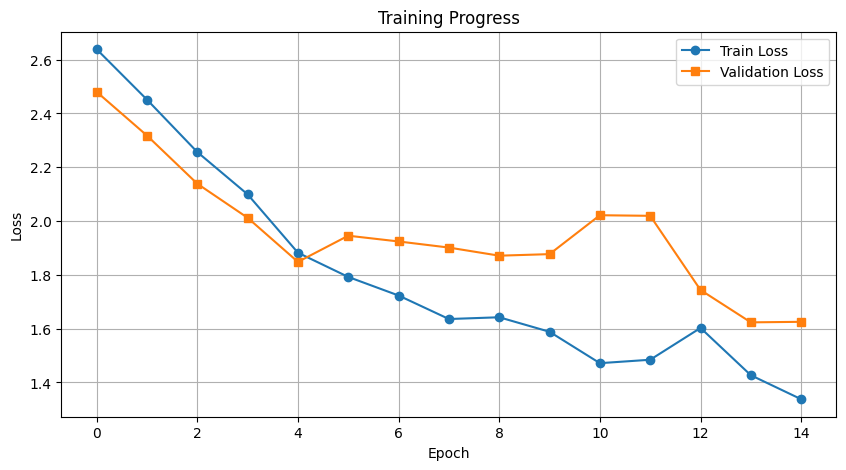

In [11]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()

## 9. Testing and Examples

In [12]:
def translate_date(model, date_str, src_vocab, tgt_vocab, device):
    """Translate a single date string"""
    model.eval()
    
    # Encode
    src_indices = src_vocab.encode(date_str.lower())
    src_tensor = torch.tensor([src_indices], dtype=torch.long).to(device)
    src_lengths = torch.tensor([len(src_indices)], dtype=torch.long).to(device)
    
    # Translate
    with torch.no_grad():
        translation = model.translate(src_tensor, src_lengths, max_len=15)
    
    # Decode
    output_str = tgt_vocab.decode(translation[0].cpu().numpy())
    return output_str

# Test examples
test_examples = [
    "25 december 2023",
    "jan 15 2020",
    "february 28 2022",
    "10/05/2021",
    "march 1 2019",
    "05-20-2023",
]

print("DATE FORMAT TRANSLATION RESULTS")

for date_str in test_examples:
    translated = translate_date(model, date_str, src_vocab, tgt_vocab, device)
    print(f"Input:  {date_str:25s} → Output: {translated}")

DATE FORMAT TRANSLATION RESULTS
Input:  25 december 2023          → Output: 2003-0--
Input:  jan 15 2020               → Output: 2003-0--
Input:  february 28 2022          → Output: 2003--0-
Input:  10/05/2021                → Output: 2003--0-
Input:  march 1 2019              → Output: 200--0-1
Input:  05-20-2023                → Output: 2003-0--


## 10. Accuracy Evaluation

In [13]:
def calculate_accuracy(model, dataloader, src_vocab, tgt_vocab, device):
    """Calculate exact match accuracy"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for src, tgt, src_lengths in tqdm(dataloader, desc="Calculating accuracy"):
            src, tgt = src.to(device), tgt.to(device)
            src_lengths = src_lengths.to(device)
            
            # Translate
            translations = model.translate(src, src_lengths, max_len=15)
            
            # Compare with target (excluding <SOS> and <EOS>)
            for i in range(src.shape[0]):
                pred = tgt_vocab.decode(translations[i].cpu().numpy())
                true = tgt_vocab.decode(tgt[i].cpu().numpy())
                
                if pred == true:
                    correct += 1
                total += 1
    
    accuracy = correct / total
    return accuracy

# Calculate accuracy
val_accuracy = calculate_accuracy(model, val_loader, src_vocab, tgt_vocab, device)
print(f"\nValidation Accuracy: {val_accuracy*100:.2f}%")

Calculating accuracy: 100%|██████████| 1/1 [00:00<00:00, 247.28it/s]


Validation Accuracy: 0.00%
